# Evidencia de aprendizaje 3: Proyecto integrador

 * **Trabajo realizado por: Juan David Ramírez García**
 * **Docente: Andres Felipe Callejas Jaramillo**
 * **Universidad: IUDigital del Antioquia**

In [0]:
#Librerías necesarias para este proyecto.
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

#### En la segunda actividad de aprendizaje se crearon las tablas `pacientes` e `historial`


In [0]:
%sql
use catalog estudios_oncologicos;
use schema pacientescancerpulmon;
show tables;

database tableName isTemporary pacientescancerpulmon historial false pacientescancerpulmon lung_cancer_staging false pacientescancerpulmon pacientes false pacientescancerpulmon resumen_mensual_diagnostico false pacientescancerpulmon resumen_mensual_end false

#### Convirtiendo las tablas pacientes e historial en dataFrames de Spark

In [0]:
df_pacientes=spark.table('pacientes')
df_historial=spark.table('historial')

In [0]:
# Mostrando 5 filas del dataFRame
display(df_pacientes.limit(5)) 
display(df_historial.limit(5))

id age gender country family_history smoking_status cirrhosis other_cancer bmi 189 30.0 Male Slovakia true Former Smoker false false 42.5 985 54.0 Female Sweden true Current Smoker false false 20.7 6404 37.0 Male Estonia false Current Smoker true false 26.7 7105 67.0 Male Austria true Never Smoked false false 34.9 8106 57.0 Female Austria true Passive Smoker false false 18.8

patient_id diagnosis_date cancer_stage cholesterol_level hypertension asthma end_treatment_date treatment_type survived 1 2016-04-05 Stage I 199 false false 2017-09-10 Chemotherapy false 2 2023-04-20 Stage III 280 true true 2024-06-17 Surgery true 3 2023-04-05 Stage III 268 true true 2024-04-09 Combined false 4 2016-02-05 Stage I 241 true true 2017-04-23 Chemotherapy false 5 2023-11-29 Stage I 178 false false 2025-01-08 Combined false

## 1. Transformaciones de fecha

Vamos a transformar el tipo de dato de las columnas `diagnosis_date` y `end_treatment_date`, de la tabla historial, que estan en tipo `string` por tipo `date`.

In [0]:
# Visualizando el tipo de las columnas antes de transformarlas.
df_historial.printSchema()

root
 |-- patient_id: integer (nullable = true)
 |-- diagnosis_date: string (nullable = true)
 |-- cancer_stage: string (nullable = true)
 |-- cholesterol_level: integer (nullable = true)
 |-- hypertension: boolean (nullable = true)
 |-- asthma: boolean (nullable = true)
 |-- end_treatment_date: string (nullable = true)
 |-- treatment_type: string (nullable = true)
 |-- survived: boolean (nullable = true)



In [0]:
# Convierto las columnas de fechas de la tabla historial al formato timestamp_str
df_historial = df_historial.withColumn("diagnosis_date", F.to_date("diagnosis_date"))
df_historial = df_historial.withColumn("end_treatment_date", F.to_date("end_treatment_date"))



Ya podemos observar que las columnas `diagnosis_date` y `end_treatment_date` ya estan en formato date.

In [0]:
display(df_historial.limit(5))

patient_id diagnosis_date cancer_stage cholesterol_level hypertension asthma end_treatment_date treatment_type survived 1 2016-04-05 Stage I 199 false false 2017-09-10 Chemotherapy false 2 2023-04-20 Stage III 280 true true 2024-06-17 Surgery true 3 2023-04-05 Stage III 268 true true 2024-04-09 Combined false 4 2016-02-05 Stage I 241 true true 2017-04-23 Chemotherapy false 5 2023-11-29 Stage I 178 false false 2025-01-08 Combined false

#### Derivando nuevas variables dede la columna `diagnosis_date`:
* anio_diagnosis: año del diagnóstico de la enfermedad
* mes_diagnosis: mes del diagnóstico de la enfermedad
* dia_diagnosis: día del mes del diagnóstico de la enfermedad
* dia_semana_diagnosis: día de la semana del diagnóstico de la enfermedad (1,2,3,..,7)
* nombre_dia_diagnosis: nombre del dia la semana del diagnóstico de la enfermedad

In [0]:
df_historial = (
  df_historial
    .withColumn("anio_diagnosis", F.year("diagnosis_date"))
    .withColumn("mes_diagnosis", F.month("diagnosis_date"))
    .withColumn("dia_diagnosis", F.dayofmonth("diagnosis_date"))
    .withColumn("dia_semana_diagnosis", F.dayofweek("diagnosis_date"))
    .withColumn("nombre_dia_diagnosis", F.date_format("diagnosis_date", "EEEE"))
)

#### Derivando nuevas variables desde la columna `end_treatment_date`:
* anio_end: año del fin del tratamiento
* mes_end: mes del fin del tratamiento
* dia_end: día del mes del fín del tratamiento
* dia_semana_end: día de la semana del fin del tratamiento (1,2,3,..,7)
* nombre_dia_end: nombre del dia la semana del fin del tratamiento

In [0]:
df_historial = (
  df_historial
    .withColumn("anio_end", F.year("end_treatment_date"))
    .withColumn("mes_end", F.month("end_treatment_date"))
    .withColumn("dia_end", F.dayofmonth("end_treatment_date"))
    .withColumn("dia_semana_end", F.dayofweek("end_treatment_date"))
    .withColumn("nombre_dia_end", F.date_format("end_treatment_date", "EEEE"))
)

In [0]:
df_historial.printSchema()


root
 |-- patient_id: integer (nullable = true)
 |-- diagnosis_date: date (nullable = true)
 |-- cancer_stage: string (nullable = true)
 |-- cholesterol_level: integer (nullable = true)
 |-- hypertension: boolean (nullable = true)
 |-- asthma: boolean (nullable = true)
 |-- end_treatment_date: date (nullable = true)
 |-- treatment_type: string (nullable = true)
 |-- survived: boolean (nullable = true)
 |-- anio_diagnosis: integer (nullable = true)
 |-- mes_diagnosis: integer (nullable = true)
 |-- dia_diagnosis: integer (nullable = true)
 |-- dia_semana_diagnosis: integer (nullable = true)
 |-- nombre_dia_diagnosis: string (nullable = true)
 |-- anio_end: integer (nullable = true)
 |-- mes_end: integer (nullable = true)
 |-- dia_end: integer (nullable = true)
 |-- dia_semana_end: integer (nullable = true)
 |-- nombre_dia_end: string (nullable = true)



Las nuevas variables como **anio_diagnosis, anio_end, mes_diagnosis y mes_diagnosis**, obtenidas de las columnas `diagnosis_data` y `end_treatment` permiten hacer un seguimiento de la evolución de los paciente según el tipo de tratamiento: cirugía, quimioterapia, etc. Asimismo calcular la duración del tratamiento y poder identifcar patrones de mejoría en rangos de tiempos específicos.

In [0]:
display(df_historial.limit(5))

patient_id diagnosis_date cancer_stage cholesterol_level hypertension asthma end_treatment_date treatment_type survived anio_diagnosis mes_diagnosis dia_diagnosis dia_semana_diagnosis nombre_dia_diagnosis anio_end mes_end dia_end dia_semana_end nombre_dia_end 1 2016-04-05 Stage I 199 false false 2017-09-10 Chemotherapy false 2016 4 5 3 Tuesday 2017 9 10 1 Sunday 2 2023-04-20 Stage III 280 true true 2024-06-17 Surgery true 2023 4 20 5 Thursday 2024 6 17 2 Monday 3 2023-04-05 Stage III 268 true true 2024-04-09 Combined false 2023 4 5 4 Wednesday 2024 4 9 3 Tuesday 4 2016-02-05 Stage I 241 true true 2017-04-23 Chemotherapy false 2016 2 5 6 Friday 2017 4 23 1 Sunday 5 2023-11-29 Stage I 178 false false 2025-01-08 Combined false 2023 11 29 4 Wednesday 2025 1 8 4 Wednesday

## 2. Resumen mensual: Tabla

### En la siguiente tabla vamos a mostrar el resumen mensual de pacientes diagnósticados con cancer de pulmon.

In [0]:
resumen_mensual_diagnostico = (df_historial.groupBy("anio_diagnosis", "mes_diagnosis")
  .agg(
    # Número de pacientes diganosticados este mes
    F.count("*").alias("n_registros"),
    
    # Pacientes únicos que recibieron tratamiento este mes
    F.countDistinct("patient_id").alias("n_pacientes_unicos"),
    
    # Promedio de los niveles de colesterol en los apcientes
    F.avg("cholesterol_level").alias("colesterol_promedio"),
    
    # Número de casos con cáncer en estadio 'IV'
    F.sum(F.when(F.col("cancer_stage") == "Stage IV", 1).otherwise(0)).alias("casos_stage_iv")
  )
  .orderBy("anio_diagnosis", "mes_diagnosis")
)

resumen_mensual_diagnostico.write.mode("overwrite").saveAsTable("resumen_mensual_diagnostico")

In [0]:
display(resumen_mensual_diagnostico.limit(10))

anio_diagnosis mes_diagnosis n_registros n_pacientes_unicos colesterol_promedio casos_stage_iv 2014 6 6988 6988 234.09001144819692 1795 2014 7 7496 7496 232.4601120597652 1888 2014 8 7552 7552 233.93842690677965 1874 2014 9 7261 7261 233.34031125189367 1745 2014 10 7708 7708 232.8681888946549 1956 2014 11 7302 7302 233.75445083538756 1788 2014 12 7462 7462 233.79295095148754 1863 2015 1 7654 7654 233.65508230990332 1905 2015 2 6843 6843 233.833114131229 1735 2015 3 7509 7509 233.4189639099747 1836

### Ahora crearemos el resumen mensual de los pacientes que terminaron el tratamiento contra el cancer de pulmon

In [0]:
resumen_mensual_end=(df_historial.groupBy("anio_end", "mes_end")
  .agg(
    # Número de pacientes que terminaron tratamiento este mes
    F.count("*").alias("n_registros"),
    # Pacientes únicos que terminaron tratamiento este mes
    F.countDistinct("patient_id").alias("n_pacientes_unicos"),
    # Promedio de los niveles de colesterol en los apcientes
    F.avg("cholesterol_level").alias("promedio_niveles_colesterol"),
    # Número de casos con cáncer en estadio 'IV'
    F.sum(F.when(F.col("cancer_stage") == "Stage IV", 1).otherwise(0)).alias("casos_stage_iv")
    )
  .orderBy("anio_end", "mes_end")
)
resumen_mensual_end.write.mode("overwrite").saveAsTable("resumen_mensual_end")

In [0]:
display(resumen_mensual_end.limit(10))

anio_end mes_end n_registros n_pacientes_unicos promedio_niveles_colesterol casos_stage_iv 2014 12 149 149 233.43624161073825 68 2015 1 438 438 235.13926940639269 172 2015 2 680 680 235.41470588235293 279 2015 3 1043 1043 233.43720038350912 428 2015 4 1277 1277 232.47768206734534 514 2015 5 1684 1684 232.39964370546318 706 2015 6 2077 2077 234.08040442946557 837 2015 7 2786 2786 233.9038047379756 944 2015 8 3415 3415 233.66559297218154 1132 2015 9 3912 3912 234.2788854805726 1296

## 3. Limpieza: antes/después

###Para esta parte de limpieza vamos a trabajar con la tabla `pacientes`

In [0]:
from pyspark.sql import functions as F, types as T

df_original = df_pacientes
df_pacientes_limpiando = df_original

# 1. Limpieza de Texto del columna estado del fumador
df_pacientes_limpiando = df_pacientes_limpiando.withColumn(
    "smoking_status_clean",
    F.lower(F.trim(F.col("smoking_status")))
)

# 2. Limpieza de Edad (Nulos y Negativos)
df_pacientes_limpiando = df_pacientes_limpiando.withColumn(
    "age_clean", 
    F.when(
        (F.col("age").isNull()) | (F.col("age") < 0), 
        None
    ).otherwise(F.col("age")).cast(T.IntegerType())
)

# 3. Imputación de Edad con la Media
media_age = df_pacientes_limpiando.select(F.avg("age_clean")).collect()[0][0]
media_age_int = int(media_age) if media_age is not None else 0

print(f"Imputando edad con la media: {media_age_int}")
df_pacientes_limpiando = df_pacientes_limpiando.na.fill({"age_clean": media_age_int})

# 4. Eliminación de Outliers (IQR)
q25, q75 = df_pacientes_limpiando.approxQuantile("age_clean", [0.25, 0.75], 0.01)
iqr = q75 - q25
low = q25 - 1.5 * iqr
high = q75 + 1.5 * iqr

df_pacientes_imputado = df_pacientes_limpiando.filter(
    (F.col("age_clean") >= low) & (F.col("age_clean") <= high)
)

# 5. Comparación Final
print("--- Datos Originales ---")
df_original.select("smoking_status", "age").show(5)

print("--- Datos Limpios ---")
df_pacientes_imputado.select("smoking_status_clean", "age_clean").show(5)

Imputando edad con la media: 55
--- Datos Originales ---
+--------------+----+
|smoking_status| age|
+--------------+----+
| Former Smoker|30.0|
|Current Smoker|54.0|
|Current Smoker|37.0|
|  Never Smoked|67.0|
|Passive Smoker|57.0|
+--------------+----+
only showing top 5 rows
--- Datos Limpios ---
+--------------------+---------+
|smoking_status_clean|age_clean|
+--------------------+---------+
|       former smoker|       30|
|      current smoker|       54|
|      current smoker|       37|
|        never smoked|       67|
|      passive smoker|       57|
+--------------------+---------+
only showing top 5 rows


**Justificación**: 
* Se limpiaron los estados de la columna `smoking_status` para evitar inconsistencias cuando se vaya agrupar con letras mayúsculas y se elimino espacios iniciales y finales para asegurar que cada estado del fumador no tenga problemas de identificación.
* Se filtraron los datos nulos y negativos en la edad de los pacientes y se casteó la columna a entero para asegurar consistencia y evitar edades negativas que no son válidas.
* Se imputo la media de la edad para no perder datos del paciente que puedan ser relavantes para un próximo análisis.
* Se eliminaron datos atípicos para evitar que influyan en la descripción de los datos y estadisticas de los pacientes.



## 4. Visualizaciones por agrupaciones categóricas

In [0]:
#Uniendo los DataFrames df_pacientes_imputado y df_historial
df_unido = df_pacientes_imputado.join(
    df_historial,
    df_pacientes_imputado.id == df_historial.patient_id
)
display(df_unido)

id age gender country family_history smoking_status cirrhosis other_cancer bmi smoking_status_clean age_clean patient_id diagnosis_date cancer_stage cholesterol_level hypertension asthma end_treatment_date treatment_type survived anio_diagnosis mes_diagnosis dia_diagnosis dia_semana_diagnosis nombre_dia_diagnosis anio_end mes_end dia_end dia_semana_end nombre_dia_end 1021 45.0 Female Italy false Never Smoked true false 33.4 never smoked 45 1021 2022-10-17 Stage IV 246 true false 2023-06-06 Chemotherapy false 2022 10 17 2 Monday 2023 6 6 3 Tuesday 2737 52.0 Male Bulgaria true Passive Smoker false false 35.3 passive smoker 52 2737 2016-09-25 Stage III 297 true true 2018-02-25 Chemotherapy true 2016 9 25 1 Sunday 2018 2 25 1 Sunday 2936 67.0 Female Romania true Passive Smoker false false 22.2 passive smoker 67 2936 2022-08-13 Stage II 215 false true 2023-10-06 Radiation false 2022 8 13 7 Saturday 2023 10 6 6 Friday 3139 51.0 Male Denmark true Never Smoked false true 36.2 never smoked 51 3139 2020-06-20 Stage I 244 false false 2021-08-27 Surgery false 2020 6 20 7 Saturday 2021 8 27 6 Friday 3683 60.0 Female Slovenia true Never Smoked false true 28.2 never smoked 60 3683 2021-06-12 Stage III 219 true true 2022-07-28 Radiation false 2021 6 12 7 Saturday 2022 7 28 5 Thursday 4366 52.0 Female Cyprus false Never Smoked true false 26.9 never smoked 52 4366 2022-11-19 Stage II 193 true true 2023-10-24 Combined true 2022 11 19 7 Saturday 2023 10 24 3 Tuesday 4885 60.0 Male Ireland true Never Smoked true false 42.6 never smoked 60 4885 2016-12-10 Stage IV 285 false true 2018-01-11 Chemotherapy false 2016 12 10 7 Saturday 2018 1 11 5 Thursday 5156 63.0 Female Poland false Passive Smoker false true 40.1 passive smoker 63 5156 2019-10-11 Stage I 274 true false 2020-12-04 Combined true 2019 10 11 6 Friday 2020 12 4 6 Friday 11451 58.0 Male Lithuania false Current Smoker false false 16.3 current smoker 58 11451 2017-09-15 Stage II 207 true false 2019-01-06 Chemotherapy false 2017 9 15 6 Friday 2019 1 6 1 Sunday 12451 61.0 Female Italy false Former Smoker false false 17.2 former smoker 61 12451 2020-03-22 Stage IV 221 true false 2021-04-10 Chemotherapy false 2020 3 22 1 Sunday 2021 4 10 7 Saturday 12914 50.0 Male Austria true Never Smoked false false 39.8 never smoked 50 12914 2022-01-25 Stage II 249 false false 2023-08-27 Surgery true 2022 1 25 3 Tuesday 2023 8 27 1 Sunday 14322 52.0 Female Hungary false Former Smoker false false 38.6 former smoker 52 14322 2019-05-03 Stage II 268 false false 2020-01-21 Surgery false 2019 5 3 6 Friday 2020 1 21 3 Tuesday 14397 58.0 Female Sweden true Current Smoker false false 20.9 current smoker 58 14397 2021-06-28 Stage III 176 true true 2022-08-15 Chemotherapy false 2021 6 28 2 Monday 2022 8 15 2 Monday 15277 44.0 Female Malta true Current Smoker false false 23.6 current smoker 44 15277 2020-05-31 Stage III 162 true false 2021-05-11 Surgery false 2020 5 31 1 Sunday 2021 5 11 3 Tuesday 16557 42.0 Male Malta false Passive Smoker false false 38.7 passive smoker 42 16557 2023-12-29 Stage IV 294 true true 2024-08-18 Surgery false 2023 12 29 6 Friday 2024 8 18 1 Sunday 17149 61.0 Male Hungary true Never Smoked false false 25.0 never smoked 61 17149 2024-01-24 Stage IV 200 false true 2025-06-20 Radiation false 2024 1 24 4 Wednesday 2025 6 20 6 Friday 18714 72.0 Female Lithuania true Never Smoked false false 21.7 never smoked 72 18714 2016-06-25 Stage III 156 true false 2017-07-04 Combined false 2016 6 25 7 Saturday 2017 7 4 3 Tuesday 19293 61.0 Male France false Never Smoked false false 44.3 never smoked 61 19293 2019-04-10 Stage IV 291 true false 2020-12-20 Chemotherapy false 2019 4 10 4 Wednesday 2020 12 20 1 Sunday 21376 52.0 Female Latvia true Passive Smoker false false 36.1 passive smoker 52 21376 2015-11-28 Stage I 251 false false 2017-08-13 Surgery false 2015 11 28 7 Saturday 2017 8 13 1 Sunday 22731 53.0 Female Bulgaria false Former Smoker false false 43.9 former smoker 53 22731 2016-01-02 Stage III 266 tru

#### Matplotlib: visualización de cómo se distribuyen los tipos de fumadores por año de diganostico

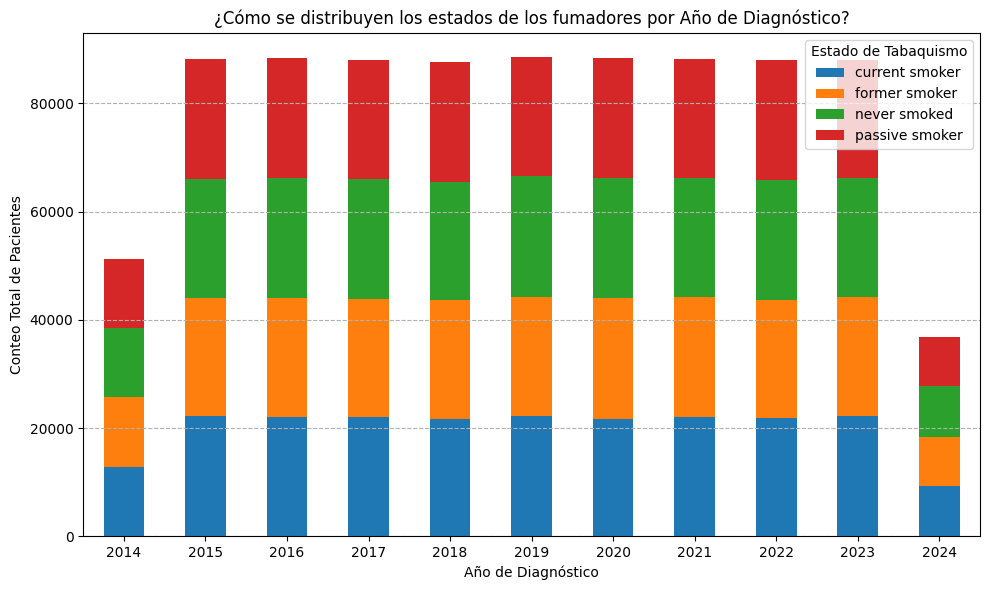

In [0]:
pdf = df_unido.select("smoking_status_clean", "anio_diagnosis", "mes_diagnosis").toPandas()

# 1. Agrupar por Año y Estado de Tabaquismo
conteo_anual = pdf.groupby(['anio_diagnosis', 'smoking_status_clean']).size()

# 2. Pivotar (unstack) el conteo para que los estados de tabaquismo sean columnas
distribucion_anual = conteo_anual.unstack(level='smoking_status_clean', fill_value=0)

# 3. Generar el Gráfico de Barras Apiladas
plt.figure(figsize=(10, 6))

# Usamos kind='bar' y stacked=True para ver la distribución anual
distribucion_anual.plot(kind='bar', stacked=True, ax=plt.gca())

# Título llamativo y relevante
plt.title("¿Cómo se distribuyen los estados de los fumadores por Año de Diagnóstico?")
plt.xlabel("Año de Diagnóstico")
plt.ylabel("Conteo Total de Pacientes")
plt.legend(title='Estado de Tabaquismo')
plt.xticks(rotation=0) # Mantenemos los años sin rotación si son pocos
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

* El año con menor diagnósticos de **cancer de pulmon** en el estudio fue **2024** con un poco menos de **40000 mil dignósticos**, mostrando una distribución equivalente entre el tipo de fumadores. Seguido del año **2014** con menos diagnósticos y con igual distribución en el tipo de fumadores. El resto de años entre **2015 y 2023** con alrededor de 89000 diagnósticos anuales, tambien mostró una distribución equivalente entre el tipo de fumadores.

#### Seaborn: visualización de cómo se distribuye el status del paciente al finalizar el tratamiento

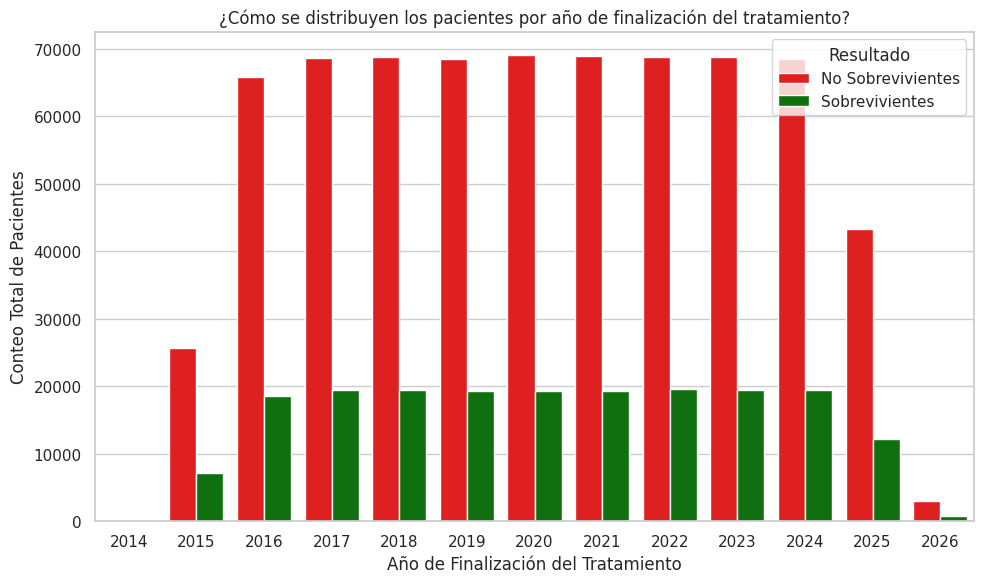

In [0]:
# Preparando datos para Seaborn
pdf_survival = df_unido.select("survived", "anio_end").toPandas()
pdf_survival.dropna(subset=['anio_end'], inplace=True) 

# Agrupación por año y estado de supervivencia
conteo_sobrevivencia = pdf_survival.groupby(['anio_end', 'survived']).size().reset_index(name='count')

# mapeo de booleanos a texto
conteo_sobrevivencia['survival_status'] = conteo_sobrevivencia['survived'].map(
    {True: 'Sobrevivientes', False: 'No Sobrevivientes'}
)

# Generar el Gráfico de Barras Agrupadas
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.barplot(
    data=conteo_sobrevivencia,
    x='anio_end',
    y='count',
    hue='survival_status', # Usamos la nueva columna de texto
    palette={'Sobrevivientes': 'green', 'No Sobrevivientes': 'red'} # Usamos las claves de texto
)

# Configuración de Etiquetas y Título
plt.title("¿Cómo se distribuyen los pacientes por año de finalización del tratamiento?")
plt.xlabel("Año de Finalización del Tratamiento")
plt.ylabel("Conteo Total de Pacientes")
# Dejamos que Seaborn maneje la leyenda, solo establecemos el título
plt.legend(title='Resultado') 

plt.tight_layout()
plt.show()

Desde **2015**, año en que se tienen registros del fin de los tratamientos, estamos viendo una mayor cantidad de personas que no sobrevivieron frente a las que sí lo hicieron. Asimismo, en los años posteriores, estamos notando un incremento constante de pacientes que se mantuvo entre **2016 y 2024**. Este periodo refleja que, aunque el mayor número de pacientes no sobrevivió al tratamiento, una menor, pero consistente, proporción lo hizo. Esto está mostrando la alta mortalidad y fatalidad de esta enfermedad, pero también que los tratamientos lograron mantener una consistencia en el número de sobrevivientes.

## 5. Explicación de puntos realizados

1. **Transformaciones de Fecha :** Del módulo de funciones de Pyspark llamado F se transformó de tipo String a Date las columnas “giagnosis_date” y “” end_treatment” de la tabla Historial, usando la instrucción `F.to_date()`. Asimismo, de estas columnas se calcularon nuevas columnas como el año, mes y día de diagnóstico y de fin de tratamiento con las instrucciones: `F.year, F.month y F.day of month`.

2. **Resumen mensual :** Con el módulo de funciones creamos dos tablas para mostrar el resumen de pacientes diagnosticados y que terminaron el tratamiento. Se calcularon nuevas columnas como el número de pacientes diagnosticados y número de pacientes que terminaron el tratamiento mensualmente, usando `F.count`; el promedio de niveles de colesterol con `F.avg` y número de pacientes en estadio IV de cáncer a la hora del diagnóstico y al terminar el tratamiento.

3. **Limpieza antes y después :** De la tabla pacientes y usando el módulo de funciones se hizo limpieza de datos como borrar espacios al inicio y al final, y convertir letras mayúsculas a minúsculas de la columna smoking_status con instrucciones `F.lower` y `F.trim`. Asimismo, de datos nulos y negativos de la variable Edad con condicionales e instrucciones como: 
`(F.col("age").isNull()) | (F.col("age") < 0)`.


**Visualizaciónes**
 
4. Se uso la librería **Matplotlib** para visualizar como se distribuyen los tipos de fumadores en el año de su diagnóstico a través de un gráfico de barras usando la instrucción .plot(kind=bar,…)

5.	Se uso la librería **Seaborn** para visualizar el estado del paciente al finalizar el tratamiento con el método `sns.barplot()`.


## Enlace video explicación: 

[https://youtu.be/NHIEr-0LWNY](https://youtu.be/NHIEr-0LWNY)